In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir("drive/My Drive/HW3_template")

In [1]:
!ls

sample_data


In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [0]:
# import all stock prices 
df = pd.read_csv("TSLA.csv", index_col=0)
df1 = df['Open']
df = pd.read_csv("GOOGL.csv", index_col=0)
df2 = df['Open']
df = pd.read_csv("DJI.csv", index_col=0)
df3 = df['Open']

In [0]:
minmax_scaler = MinMaxScaler()
df1 = minmax_scaler.fit_transform(df1.values.reshape(-1,1))
df2 = minmax_scaler.fit_transform(df2.values.reshape(-1,1))
df3 = minmax_scaler.fit_transform(df3.values.reshape(-1,1))

In [0]:
def load_data(data_raw, seq_len): 
    data = []
    valid_set_percent = 0.1
    test_set_percent = 0.1
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data)
    valid_set_size = int(np.round(valid_set_percent * data.shape[0]))
    test_set_size = int(np.round(test_set_percent * data.shape[0]))
    train_set_size = data.shape[0] - (valid_set_size + test_set_size)

    x_train = data[:train_set_size,:-1]
    y_train = data[:train_set_size,-1]
    #x_train = np.squeeze(x_train)
    
    x_valid = data[train_set_size:train_set_size + valid_set_size, :-1]
    y_valid = data[train_set_size:train_set_size + valid_set_size, -1]
    #x_valid = np.squeeze(x_valid)
    
    x_test = data[train_set_size + valid_set_size:, :-1]
    y_test = data[train_set_size + valid_set_size:, -1]
    #x_test = np.squeeze(x_test)
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

In [9]:
# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df1, seq_len)
print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)
print('x_valid.shape =', x_valid.shape)
print('y_valid.shape =', y_valid.shape)
print('x_test.shape =', x_test.shape)
print('y_test.shape =', y_test.shape)

x_train.shape = (1765, 19, 1)
y_train.shape = (1765, 1)
x_valid.shape = (221, 19, 1)
y_valid.shape = (221, 1)
x_test.shape = (221, 19, 1)
y_test.shape = (221, 1)


In [0]:
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

In [11]:
n_steps = seq_len - 1 
n_inputs = 1 
n_neurons = 200 
n_outputs = 1
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 30 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:]  # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y))  # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for upd

In [12]:
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size / batch_size)):
        x_batch, y_batch = next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('epoch %d: MSE train: %.6f, MSE valid: %.6f' % (np.ceil(iteration*batch_size/train_set_size), mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})

epoch 0: MSE train: 0.120848, MSE valid: 0.446345
epoch 1: MSE train: 0.000406, MSE valid: 0.001037
epoch 2: MSE train: 0.000351, MSE valid: 0.000961
epoch 3: MSE train: 0.000311, MSE valid: 0.000913
epoch 4: MSE train: 0.000304, MSE valid: 0.000890
epoch 5: MSE train: 0.000299, MSE valid: 0.000862
epoch 6: MSE train: 0.000305, MSE valid: 0.001031
epoch 7: MSE train: 0.000266, MSE valid: 0.000847
epoch 8: MSE train: 0.000345, MSE valid: 0.001002
epoch 9: MSE train: 0.000314, MSE valid: 0.001074
epoch 10: MSE train: 0.000234, MSE valid: 0.000692
epoch 11: MSE train: 0.000234, MSE valid: 0.000704
epoch 12: MSE train: 0.000219, MSE valid: 0.000646
epoch 13: MSE train: 0.000317, MSE valid: 0.001008
epoch 14: MSE train: 0.000224, MSE valid: 0.000702
epoch 15: MSE train: 0.000204, MSE valid: 0.000623
epoch 16: MSE train: 0.000203, MSE valid: 0.000603
epoch 17: MSE train: 0.000235, MSE valid: 0.000678
epoch 18: MSE train: 0.000202, MSE valid: 0.000628
epoch 19: MSE train: 0.000284, MSE valid:

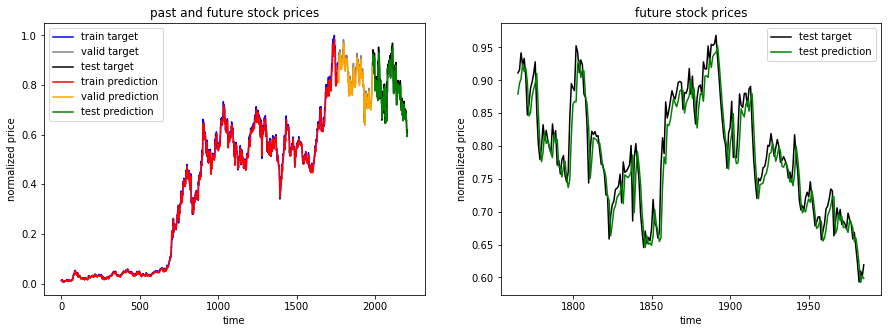

In [13]:
ft = 0   # 0 = open, 1 = close, 2 = highest, 3 = lowest

## show predictions
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft], color='gray', label='valid target')
plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0], y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')
plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')
plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')
plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')
plt.title('past and future stock prices')
plt.xlabel('time')
plt.ylabel('normalized price')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')
plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')
plt.title('future stock prices')
plt.xlabel('time')
plt.ylabel('normalized price')
plt.legend(loc='best')